In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tushare as ts
import datetime
import pandas as dp
from sklearn.model_selection import train_test_split

pro = ts.pro_api('6a556bff9d65d2106c76bbdaef29f4e690a049cc4d58266849c14d20')

2021-01-07
2021-01-15
----------
2020-01-15
2021-01-07
elaspe: 0.016044; train_score: 0.993710; cv_score: 0.991431


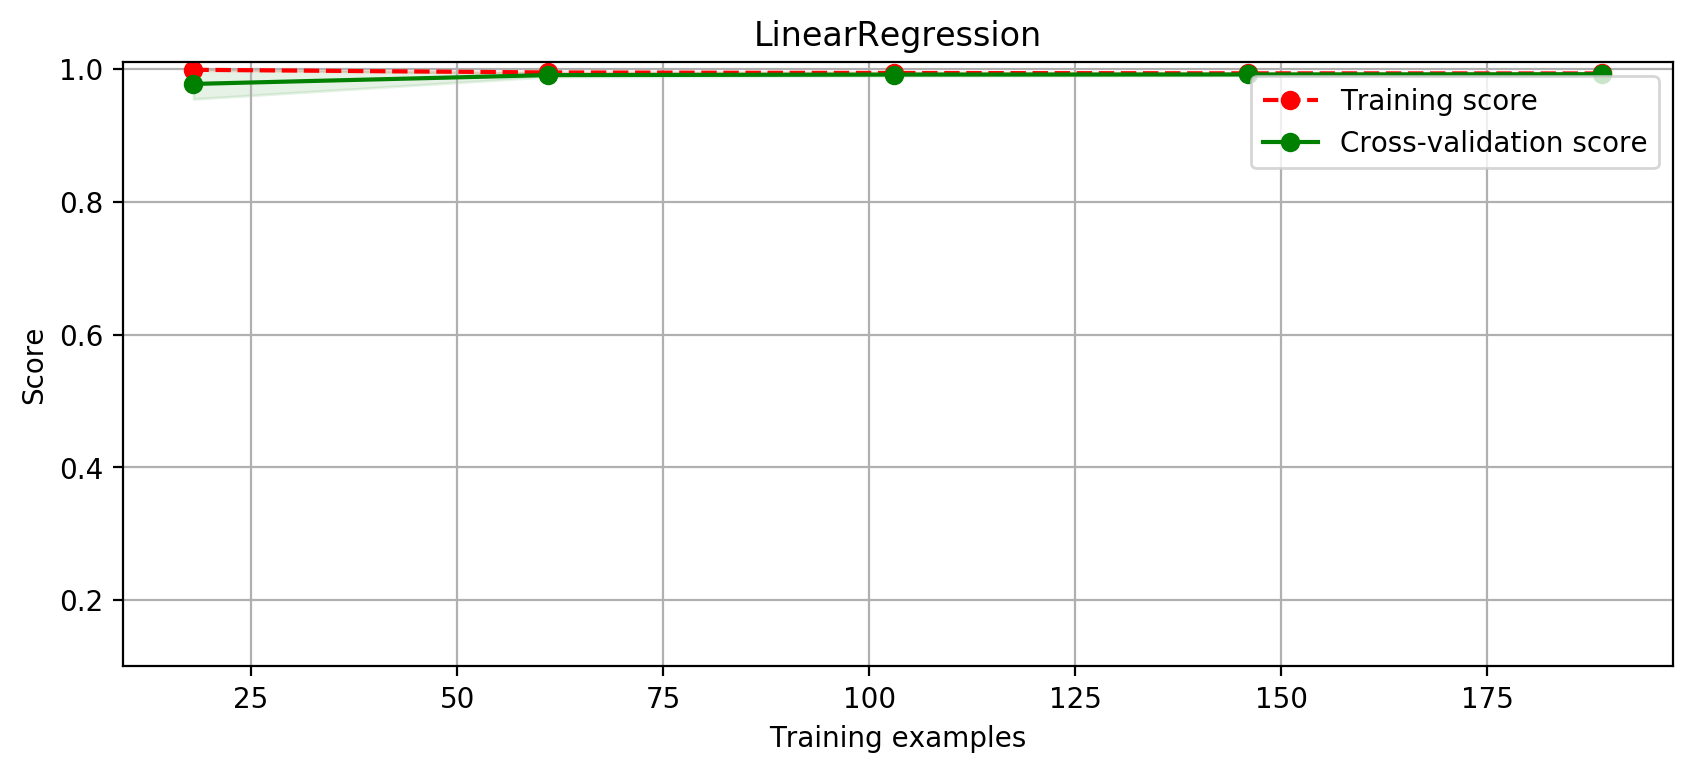

In [2]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from common.utils import plot_learning_curve

#预测开始日期与训练结束日期重叠，目的训练只要取一次数据
#预测第二日的最高价，预测数据日期需要向后偏移一天；为了减少取数次数，预测时候删除第一日，训练数据删除最后一日

#预测数据开始、结束日期
#dt4 = (datetime.datetime.now() + datetime.timedelta(days=-1)) #.strftime("%Y%m%d")
dt4 = datetime.datetime.now() #.strftime("%Y%m%d")
dt3 = dt4+datetime.timedelta(days=-8)
print(dt3.strftime("%Y-%m-%d"))
print(dt4.strftime("%Y-%m-%d"))

#训练、测试数据开始日期，结束日期
dt1 =  datetime.datetime.now()+ datetime.timedelta(days=-366)
dt2 = (dt4 + datetime.timedelta(days=-8)) #.strftime("%Y%m%d")
print("----------")
print(dt1.strftime("%Y-%m-%d"))
print(dt2.strftime("%Y-%m-%d"))

#日线行情
da = pro.daily(ts_code='600754.SH', start_date=dt1.strftime("%Y%m%d"), end_date=dt2.strftime("%Y%m%d"))
#每日指标
db = pro.daily_basic(ts_code='600754.SH',start_date=dt1.strftime("%Y%m%d"),end_date=dt2.strftime("%Y%m%d"))
sub_db= db.loc[:,['trade_date','turnover_rate','volume_ratio']]
df1 = dp.merge(da,sub_db)
#df1=da

X = df1[1:].drop(['ts_code','trade_date'],axis=1)
#print(X.columns)
#训练day+1 的最高价
y = df1[:-1]['low']
#有字段是NAN值 ，需要替换
X.fillna(0,inplace=True)
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2,shuffle=True)


model = LinearRegression()
start = time.perf_counter()
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
cv_score = model.score(X_test, y_test)
print('elaspe: {0:0.6f}; train_score: {1:0.6f}; cv_score: {2:0.6f}'.format(time.perf_counter()-start, train_score, cv_score))

plt.figure(figsize=(10,4),dpi=200)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(plt, LinearRegression(), "LinearRegression", X, y, ylim=(0.1, 1.01), cv=cv)
#参数不能过多，过多会过拟合 高方差，含义是现有数据拟合很好，新数据拟合误差大
plt.show()


[46.75781103 49.10310393 46.56307137 48.82144501 50.58042467 51.13819832]
['20210115' '20210114' '20210113' '20210112' '20210111' '20210108']
['20210114' '20210113' '20210112' '20210111' '20210108' '20210107']


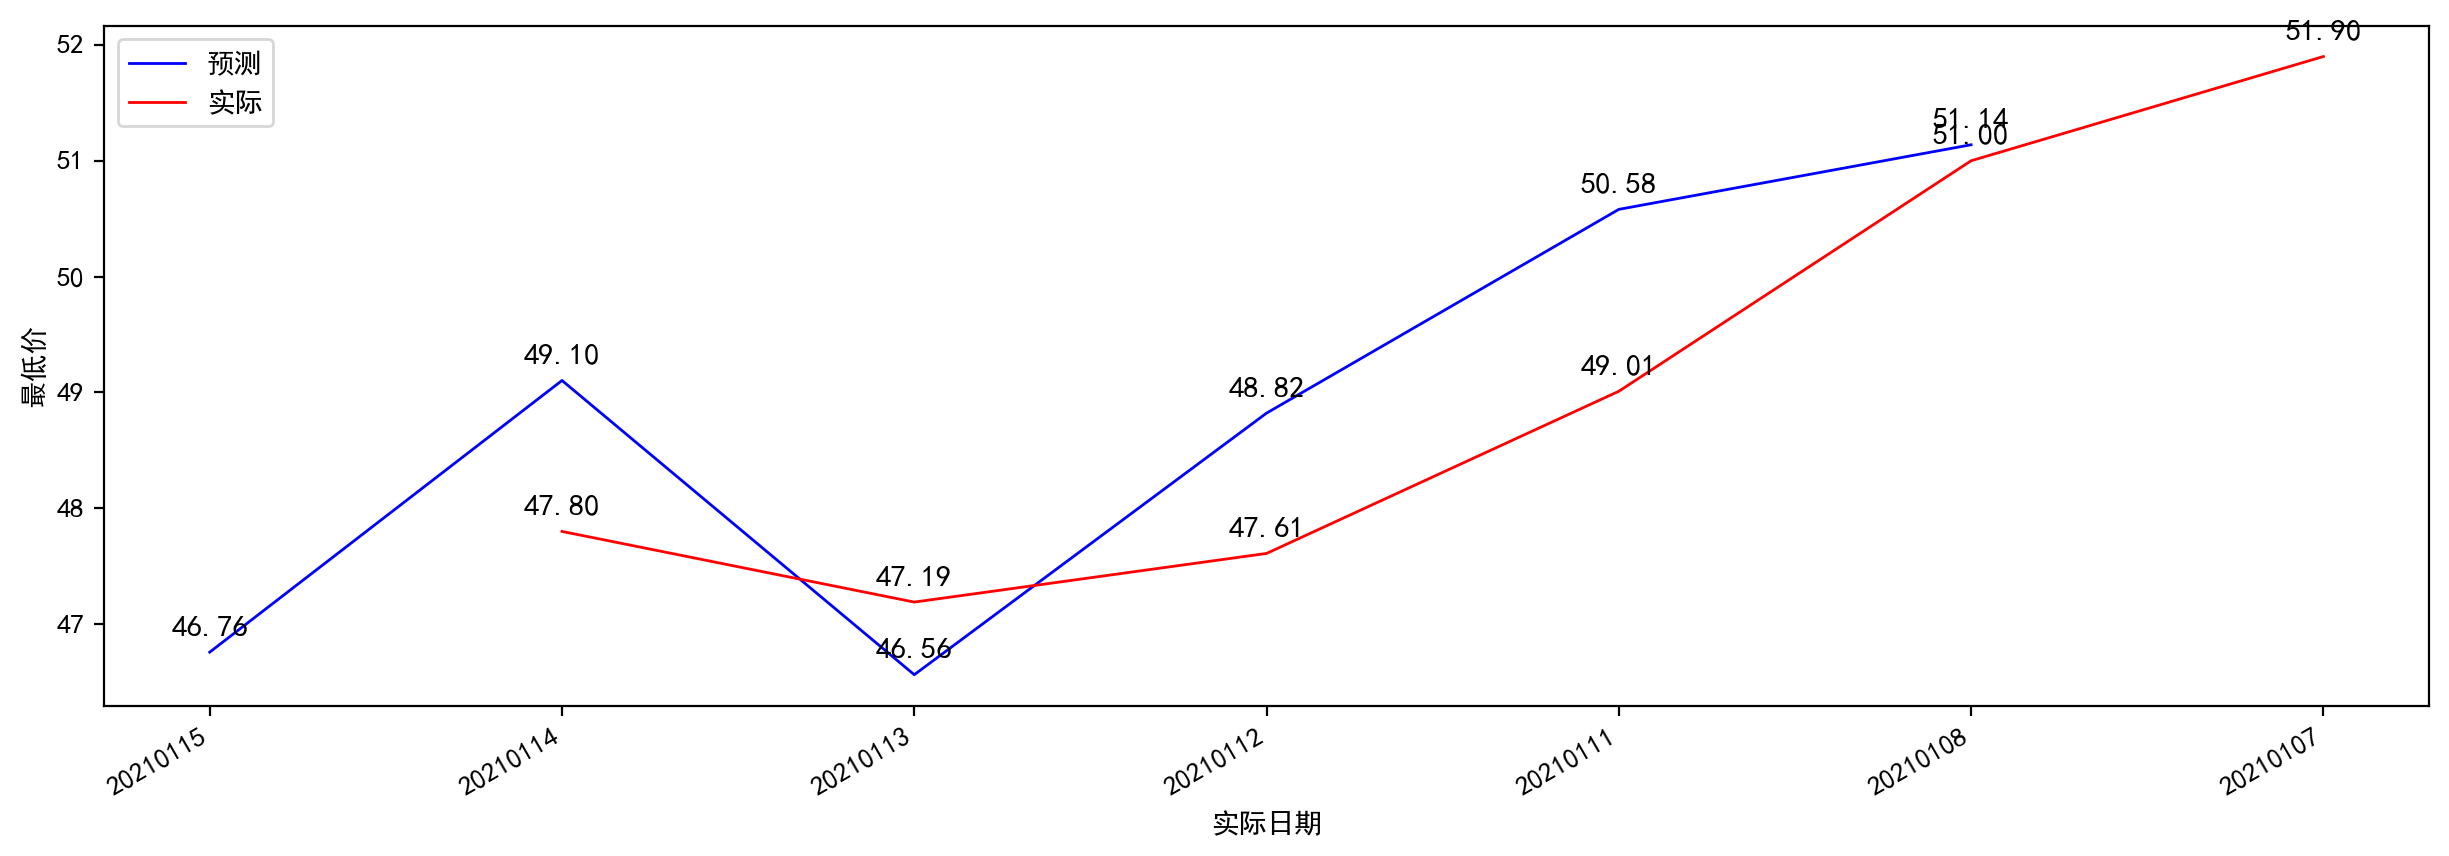

In [3]:
import matplotlib.dates as mdate

#预测数据 
p_da = pro.daily(ts_code='600754.SH', start_date=dt3.strftime("%Y%m%d"), end_date=dt4.strftime("%Y%m%d"))

p_db = pro.daily_basic(ts_code='600754.SH',start_date=dt3.strftime("%Y%m%d"),end_date=dt4.strftime("%Y%m%d"))
sub_p_db= p_db.loc[:,['trade_date','turnover_rate','volume_ratio']]
df2=dp.merge(p_da,sub_p_db)

#预测的是 daily + 1日期的数据
#删除日期列，日期列跨年引起预测数据巨大差异
df3 = df2[:].drop(['ts_code','trade_date'],axis=1)
df3.fillna(0,inplace=True)
#print(df3.columns)
#print(p_db['trade_date'])
#print(df3)
#print(df3.loc[:,['low']])
X_train_1 = model.predict(df3)
print(X_train_1)


#图形显示
plt.rcParams['font.family']=['sans-serif']
plt.rcParams['font.sans-serif']=['SimHei'] 

fig, ax = plt.subplots(figsize=(15,5),dpi=200)

y1 = X_train_1
y2 = p_da[:]['low']

#获取预测用日线行情当前日期
str_dt = p_da.iloc[0]['trade_date']
end_dt = datetime.datetime.strptime(str_dt, '%Y%m%d')+datetime.timedelta(days=+30)
#print(end_dt)

str_dt =  p_da.iloc[(p_da.iloc[:,0].size)-1]['trade_date']
start_dt = datetime.datetime.strptime(str_dt, '%Y%m%d')
#print(start_dt)

#x1 预测日期
#x2 实际日期
df_c = pro.query('trade_cal', start_date=start_dt.strftime("%Y%m%d"), 
                 end_date=end_dt.strftime("%Y%m%d"),is_open=1)
#dataframe 倒排序 .iloc[::-1]
#print(df_c)
#print(df_c['cal_date'].size)
x1 = df_c.iloc[::-1][(df_c['cal_date'].size - df3['high'].size -1 ):-1]['cal_date'].values
print(x1)

x2 = df_c.iloc[::-1][(df_c['cal_date'].size - df3['high'].size):]['cal_date'].values
print(x2)

plt.plot(x1,y1, color='blue', linewidth=1, label='预测')
for a,b in zip(x1,y1):
    plt.text(a,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=11)

plt.plot(x2,y2, color='red', linewidth=1,label='实际')
for a,b in zip(x2,y2):
    plt.text(a,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=11)
    
plt.xlabel('实际日期')
plt.ylabel('最低价')

plt.legend() 
plt.gcf().autofmt_xdate()
plt.show()

In [6]:
#平均计算误差的绝对值
#当日挂单最高价 =  预测最高价 - 平均误差
from sklearn.metrics import mean_squared_error # 均方误差
from sklearn.metrics import mean_absolute_error # 平方绝对误差
#print(df3[:-1]['high'])
#print(X_train_1[1:])
mse = mean_squared_error(df3[:-1]['low'],X_train_1[1:]) 
print(mse)
mae = mean_absolute_error(df3[:-1]['low'],X_train_1[1:])
print(mae)
#RMSE （均方根误差）（Root Mean Square Error）
rmse = np.sqrt(mse) 
print(rmse)

#建议买出价
y1[0] + rmse

0.9465688303703966
0.8269608284828488
0.9729176894118005


50.47305903920922

In [4]:
#每日收盘执行，将当日预测价格,当日实际最高低价更新
from sqlalchemy import create_engine,Table, Column, Integer, String, Float, Date, MetaData, ForeignKey
from sqlalchemy.sql import select

engine = create_engine('sqlite:///D:\\workspace\\600754.db?check_same_thread=False', echo=True)
print(engine)
metadata = MetaData()
daily_forecast = Table('daily_forecast', metadata,
              Column('id', Integer, primary_key=True),
              Column('ts_code', String),
              Column('trade_date', String),
              Column('high',Float),
              Column('forecast_high',Float),
              Column('low',Float),
              Column('forecast_low',Float)
     )

conn = engine.connect()
stmt = daily_forecast.update().where(daily_forecast.c.trade_date == x2[0]).values(forecast_low=X_train_1[1])
print(stmt.compile().params)
conn.execute(stmt)


Engine(sqlite:///D:\workspace\600754.db?check_same_thread=False)
2021-01-15 00:37:35,190 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-01-15 00:37:35,190 INFO sqlalchemy.engine.base.Engine ()
2021-01-15 00:37:35,192 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-01-15 00:37:35,192 INFO sqlalchemy.engine.base.Engine ()
{'forecast_low': 49.10310392803851, 'trade_date_1': '20210114'}
2021-01-15 00:37:35,196 INFO sqlalchemy.engine.base.Engine UPDATE daily_forecast SET forecast_low=? WHERE daily_forecast.trade_date = ?
2021-01-15 00:37:35,197 INFO sqlalchemy.engine.base.Engine (49.10310392803851, '20210114')
2021-01-15 00:37:36,199 INFO sqlalchemy.engine.base.Engine COMMIT
